In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import warnings
warnings.filterwarnings("ignore")

# Analyze the first decade

In [2]:
df_19 = pd.read_csv("TOTALSA_19.csv", parse_dates=True, index_col="DATE")
df_19.freq="MS"

In [3]:
df_19.head()

,TOTALSA
DATE,
1990-01-01,16.308
1990-02-01,14.363
1990-03-01,14.486
1990-04-01,14.281
1990-05-01,14.022


In [4]:
df_19.tail()

,TOTALSA
DATE,
1999-08-01,17.641
1999-09-01,17.662
1999-10-01,17.684
1999-11-01,17.620
1999-12-01,18.322


Let us see the data that we're working with.

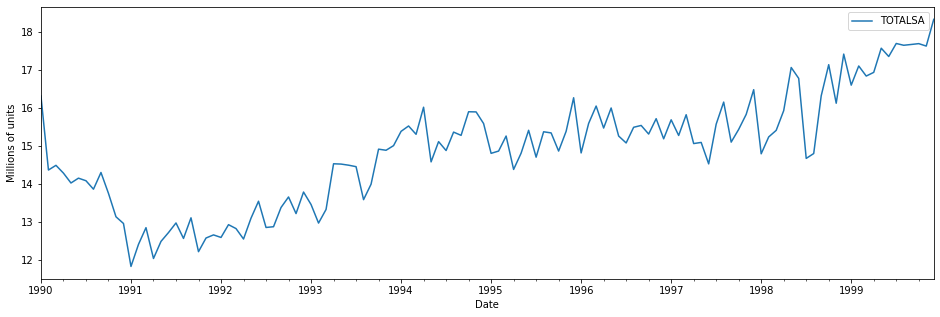

In [5]:
ax = df_19.plot(figsize=(16,5))
plt.ylabel("Millions of units")
plt.xlabel("Date")
plt.show()

Lets check the adfuller test, to see if the data is stationary.

In [6]:
adfuller(df_19.TOTALSA)

(0.627662482388793,
 0.9882779821994239,
 5,
 114,
 {'1%': -3.489057523907491,
  '5%': -2.887246327182993,
  '10%': -2.5804808802708528},
 178.24663671468213)

They are not, so we suspect that we need differencing. Lets see the result of the adfuller test after differencing by one.

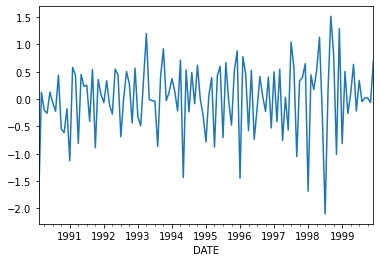

In [7]:
df_19['d1'] = df_19.TOTALSA.diff(1)
df_19.d1.dropna(inplace=True)
df_19.d1.plot();

In [8]:
adfuller(df_19.d1)

(-7.409310416655577,
 7.204209993186997e-11,
 4,
 114,
 {'1%': -3.489057523907491,
  '5%': -2.887246327182993,
  '10%': -2.5804808802708528},
 175.19172244825384)

Differencing helped. We cannot use ARMA model, we should aim for the models with differencing. ARIMA or even SARIMA. Let us look on the acf and pacf to get some idea about the order of the model.

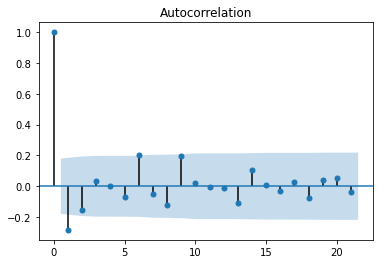

In [9]:
plot_acf(df_19.d1);

MA order around 2

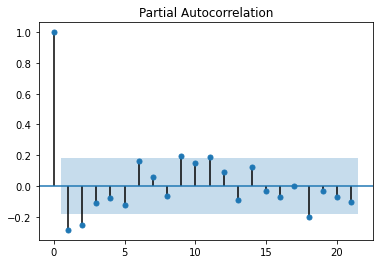

In [10]:
plot_pacf(df_19.d1);

AR model around 3.

Lets run the autoarima, and check the results.

In [11]:
auto_arima(df_19.d1).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  119
Model:               SARIMAX(2, 0, 2)   Log Likelihood                 -97.637
Date:                Wed, 03 Jun 2020   AIC                            207.273
Time:                        01:26:06   BIC                            223.948
Sample:                             0   HQIC                           214.044
                                - 119                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0047      0.009      0.513      0.608      -0.013       0.022
ar.L1          1.2565      0.097     12.950      0.000       1.066       1.447
ar.L2         -0.4963      0.111     -4.461      0.000      -0.714      -0.278
ma.L1         -1.8325      0.525     -3.489      0.000      -2.862      -0.803
ma.L2          0.9975      0.577      1.728      0.084      -0.134       2.129
sigma2         0.2883      0.167      1.727      0.084      -0.039       0.616
===================================================================================
Ljung-Box (Q):                       25.32   Jarque-Bera (JB):                 2.13
Prob(Q):                              0.97   Prob(JB):                         0.34
Heteroskedasticity (H):               1.24   Skew:                            -0.31
Prob(H) (two-sided):                  0.51   Kurtosis:                         3.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Let's check autoarima on original data, not differenced.

In [12]:
stepwise = auto_arima(
    df_19.TOTALSA,
    start_p=1,
    start_q=1,
    max_p=4,
    max_d=4,
    max_q=4,
    stepwise=False,
    trace=True,
)
stepwise.summary()

Fit ARIMA(0,1,0)x(0,0,0,1) [intercept=True]; AIC=236.950, BIC=242.509, Time=0.011 seconds
Fit ARIMA(0,1,1)x(0,0,0,1) [intercept=True]; AIC=217.801, BIC=226.138, Time=0.041 seconds
Fit ARIMA(0,1,2)x(0,0,0,1) [intercept=True]; AIC=218.121, BIC=229.237, Time=0.068 seconds
Fit ARIMA(0,1,3)x(0,0,0,1) [intercept=True]; AIC=219.152, BIC=233.048, Time=0.102 seconds
Fit ARIMA(0,1,4)x(0,0,0,1) [intercept=True]; AIC=219.056, BIC=235.731, Time=0.159 seconds
Fit ARIMA(1,1,0)x(0,0,0,1) [intercept=True]; AIC=228.078, BIC=236.415, Time=0.023 seconds
Fit ARIMA(1,1,1)x(0,0,0,1) [intercept=True]; AIC=218.629, BIC=229.745, Time=0.086 seconds
Fit ARIMA(1,1,2)x(0,0,0,1) [intercept=True]; AIC=219.719, BIC=233.614, Time=0.146 seconds
Fit ARIMA(1,1,3)x(0,0,0,1) [intercept=True]; AIC=211.741, BIC=228.416, Time=0.404 seconds
Fit ARIMA(1,1,4)x(0,0,0,1) [intercept=True]; AIC=221.501, BIC=240.955, Time=0.188 seconds
Fit ARIMA(2,1,0)x(0,0,0,1) [intercept=True]; AIC=220.979, BIC=232.096, Time=0.044 seconds
Fit ARIMA(

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:               SARIMAX(2, 1, 2)   Log Likelihood                 -97.640
Date:                Wed, 03 Jun 2020   AIC                            207.280
Time:                        01:26:20   BIC                            223.954
Sample:                             0   HQIC                           214.051
                                - 120                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0046      0.009      0.504      0.614      -0.013       0.022
ar.L1          1.2571      0.097     12.988      0.000       1.067       1.447
ar.L2         -0.4964      0.111     -4.472      0.000      -0.714      -0.279
ma.L1         -1.8311      0.314     -5.832      0.000      -2.446      -1.216
ma.L2          0.9958      0.347      2.872      0.004       0.316       1.676
sigma2         0.2879      0.103      2.792      0.005       0.086       0.490
===================================================================================
Ljung-Box (Q):                       25.31   Jarque-Bera (JB):                 2.15
Prob(Q):                              0.97   Prob(JB):                         0.34
Heteroskedasticity (H):               1.24   Skew:                            -0.31
Prob(H) (two-sided):                  0.50   Kurtosis:                         3.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The order of AR and MA match, and we see that we need the differencing.

In [13]:
def evaluate_model(model, start, test, model_name, **kwargs):
    """ Function to evaluate predictions against test set.
    
    Args:
        model: model to produce predictions
        start: start index of prediction usually len(train)
        test: test data
        model_name: name to rename the model data
        **kwargs: additional parameters for predict function
        
    Returns:
        predictions
    """
    predictions = model.predict(start=start, end=start+len(test)-1, dynamic=False, **kwargs).rename(model_name)
    print(f"MSE for {model_name}: \t{mean_squared_error(test, predictions)}")
    print(f"RMSE for {model_name}: \t{rmse(test, predictions)}")
    return predictions

In [14]:
def plot_results(test, predictions):
    """ Plots the predicted data and test data to visualise the predictions.
    
    Args:
        test: test data
        prediction: predictions data
    """
    title = "Compare prediction with test set"
    xlabel = "date"
    ylabel="Millions of units"
    
    ax = test.plot(legend=True, figsize=(12,6), title=title, label="Test data")
    predictions.plot(legend=True)
    ax.autoscale(axis="x", tight=True)
    ax.set(xlabel=xlabel, ylabel=ylabel)
    plt.show()

In [15]:
def forecast_sarima(data, order, seasonal_order=None, n=11):
    """ Forecast fr the data using defined model
    """
    if seasonal_order:
        model = SARIMAX(data, order=order, seasonal_order=seasonal_order).fit()
    else:
        model = SARIMAX(data, order=order).fit()
    return model.predict(
        len(data),
        len(data)+n,
        dynamic=False).rename(f"Forecast {order}x{seasonal_order}"
    )

In [16]:
s_index = -12
train = df_19.iloc[:s_index]
test = df_19.iloc[s_index:]

In [17]:
arima_2_1_2 = ARIMA(train.TOTALSA, order=(2,1,2)).fit()
res_arima_2_1_2 = evaluate_model(arima_2_1_2, len(train), test.TOTALSA, "ARIMA (2,1,2)", typ="levels")

MSE for ARIMA (2,1,2): 	0.44195842889575293
RMSE for ARIMA (2,1,2): 	0.6647995403847335


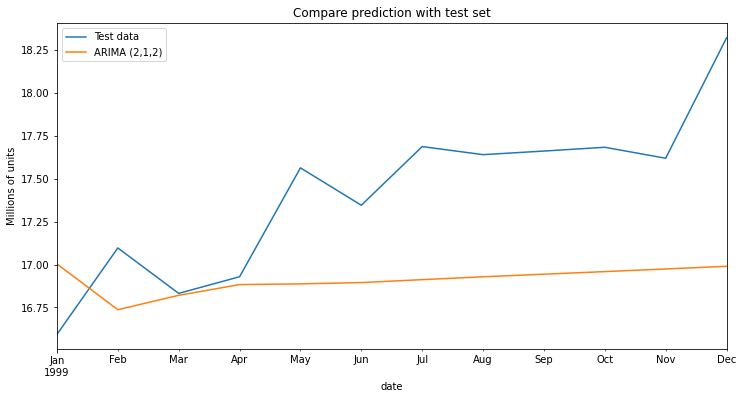

In [18]:
plot_results(test.TOTALSA, res_arima_2_1_2)

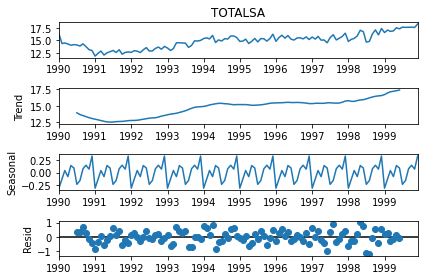

In [19]:
resd = seasonal_decompose(df_19.TOTALSA)
resd.plot();

We see that there is 1year=12 month seasonality, let us try to fit this model. Specyfing **D=1** and **d=1**

In [20]:
stepwise = auto_arima(
    df_19.TOTALSA,
    m=12,
    d=1,
    D=1,
    start_p=1,
    start_q=1,
    max_p=4,
    max_d=4,
    max_q=4,
    max_P=4,
    max_Q=4,
    stepwise=False,
    trace=True,
)
stepwise.summary()

Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=True]; AIC=290.159, BIC=295.505, Time=0.024 seconds
Fit ARIMA(0,1,0)x(0,1,1,12) [intercept=True]; AIC=238.110, BIC=246.129, Time=0.517 seconds
Fit ARIMA(0,1,0)x(0,1,2,12) [intercept=True]; AIC=239.859, BIC=250.550, Time=1.273 seconds
Fit ARIMA(0,1,0)x(0,1,3,12) [intercept=True]; AIC=241.130, BIC=254.494, Time=1.489 seconds
Fit ARIMA(0,1,0)x(0,1,4,12) [intercept=True]; AIC=243.066, BIC=259.103, Time=7.052 seconds
Fit ARIMA(0,1,0)x(1,1,0,12) [intercept=True]; AIC=262.236, BIC=270.254, Time=0.155 seconds
Fit ARIMA(0,1,0)x(1,1,1,12) [intercept=True]; AIC=239.894, BIC=250.585, Time=0.879 seconds
Fit ARIMA(0,1,0)x(1,1,2,12) [intercept=True]; AIC=241.361, BIC=254.726, Time=2.536 seconds
Fit ARIMA(0,1,0)x(1,1,3,12) [intercept=True]; AIC=242.847, BIC=258.884, Time=4.535 seconds
Fit ARIMA(0,1,0)x(1,1,4,12) [intercept=True]; AIC=244.849, BIC=263.559, Time=3.460 seconds
Fit ARIMA(0,1,0)x(2,1,0,12) [intercept=True]; AIC=250.865, BIC=261.556, Time=0.427 seconds

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  120
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 12)   Log Likelihood                 -99.981
Date:                              Wed, 03 Jun 2020   AIC                            213.961
Time:                                      01:32:29   BIC                            232.671
Sample:                                           0   HQIC                           221.546
                                              - 120                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0037      0.003      1.252      0.211      -0.002       0.010
ar.L1          1.2517      0.120     10.433      0.000       1.017       1.487
ar.L2         -0.4559      0.110     -4.144      0.000      -0.671      -0.240
ma.L1         -1.7903      0.056    -31.901      0.000      -1.900      -1.680
ma.L2          0.9428      0.050     18.892      0.000       0.845       1.041
ma.S.L12      -0.9914      3.000     -0.330      0.741      -6.871       4.888
sigma2         0.2933      0.858      0.342      0.732      -1.388       1.974
===================================================================================
Ljung-Box (Q):                       32.01   Jarque-Bera (JB):                 0.20
Prob(Q):                              0.81   Prob(JB):                         0.91
Heteroskedasticity (H):               1.27   Skew:                            -0.10
Prob(H) (two-sided):                  0.48   Kurtosis:                         3.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
arima_2_1_2_seasonal_0_1_1 = SARIMAX(
    train.TOTALSA,
    order=(2,1,2),
    seasonal_order=(0,1,1,12)
).fit()
res_arima_2_1_2_seasonal_0_1_1 = evaluate_model(
    arima_2_1_2_seasonal_0_1_1,
    len(train),
    test.TOTALSA, "SARIMA (2,1,2)x(0,1,1,12)")

MSE for SARIMA (2,1,2)x(0,1,1,12): 	0.28194837904814896
RMSE for SARIMA (2,1,2)x(0,1,1,12): 	0.5309881157315566


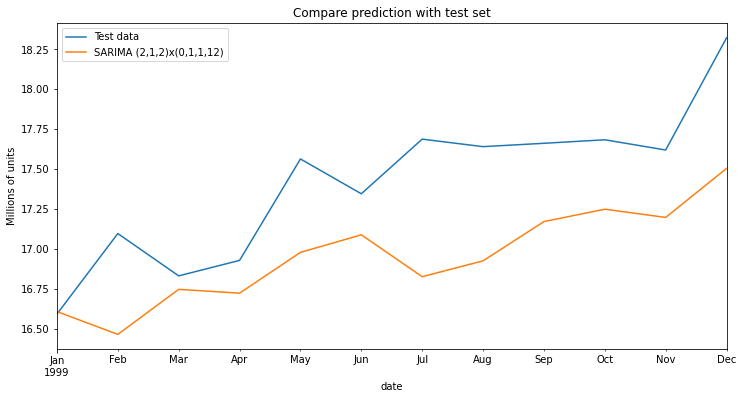

In [22]:
plot_results(test.TOTALSA, res_arima_2_1_2_seasonal_0_1_1)

What if we let the autoarima to determin the "D" parameter?

In [23]:
stepwise = auto_arima(
    df_19.TOTALSA,
    m=12,
    d=None,
    D=None,
    start_p=1,
    start_q=1,
    max_p=4,
    max_q=4,
    max_d=4,
    max_P=4,
    max_D=4,
    max_Q=4,
    stepwise=False,
    trace=True,
    n_jobs=-1
)
stepwise.summary()

Total fit time: 29.738 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:               SARIMAX(2, 1, 2)   Log Likelihood                 -97.640
Date:                Wed, 03 Jun 2020   AIC                            207.280
Time:                        01:33:31   BIC                            223.954
Sample:                             0   HQIC                           214.051
                                - 120                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0046      0.009      0.504      0.614      -0.013       0.022
ar.L1          1.2571      0.097     12.988      0.000       1.067       1.447
ar.L2         -0.4964      0.111     -4.472      0.000      -0.714      -0.279
ma.L1         -1.8311      0.314     -5.832      0.000      -2.446      -1.216
ma.L2          0.9958      0.347      2.872      0.004       0.316       1.676
sigma2         0.2879      0.103      2.792      0.005       0.086       0.490
===================================================================================
Ljung-Box (Q):                       25.31   Jarque-Bera (JB):                 2.15
Prob(Q):                              0.97   Prob(JB):                         0.34
Heteroskedasticity (H):               1.24   Skew:                            -0.31
Prob(H) (two-sided):                  0.50   Kurtosis:                         3.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
sarima_2_1_2_model = SARIMAX(train.TOTALSA,order=(2,1,2)).fit()
res_sarima_2_1_2 = evaluate_model(sarima_2_1_2_model, len(train), test.TOTALSA, "SARIMA (2,1,2)")

MSE for SARIMA (2,1,2): 	0.22900061704753993
RMSE for SARIMA (2,1,2): 	0.478540089279404


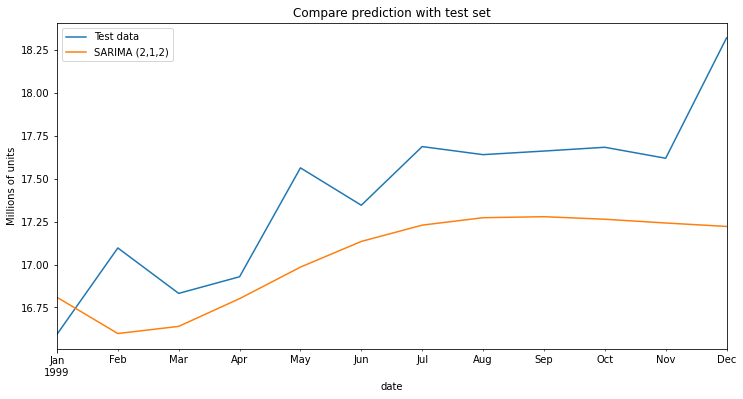

In [25]:
plot_results(test.TOTALSA, res_sarima_2_1_2)

How about exponential Smoothing method?

In [26]:
hw_es = ExponentialSmoothing(
    train.TOTALSA,
    trend='mul',
    seasonal='mul',
    seasonal_periods=12
).fit()
res_hw_es = hw_es.forecast(12).rename("Exponential Smoothing")
print(f"MSE for Exponential Smoothing: \t{mean_squared_error(test.TOTALSA, res_hw_es)}")
print(f"RMSE for Exponential Smoothing: \t{rmse(test.TOTALSA, res_hw_es)}")

MSE for Exponential Smoothing: 	0.14785876957616004
RMSE for Exponential Smoothing: 	0.3845240819196634


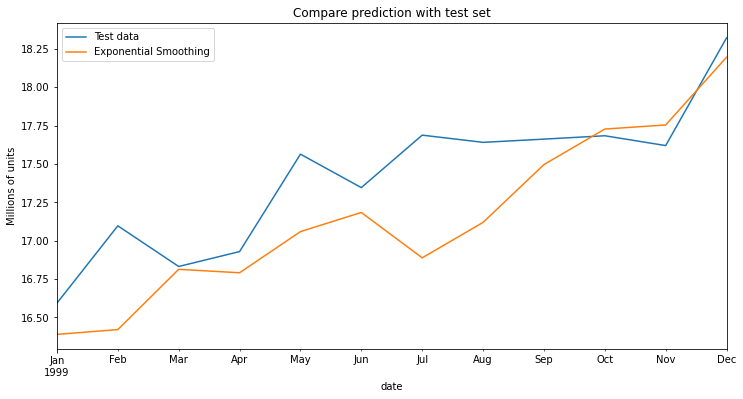

In [27]:
plot_results(test.TOTALSA, res_hw_es)

| Model                           | MSE                | RMSE            |
|-------------------------------- |:------------------:|:---------------:|
| ARIMA (2,1,2)                   | 0.441              | 0.664           |
| SARIMAX (2,1,2)x(0,1,1,12)      | 0.281              | 0.530           |
| SARIMAX (2,1,2)                 | 0.229              | 0.478           |
| **Exponential Smoothing**       | **0.147**          | **0.3845**      |

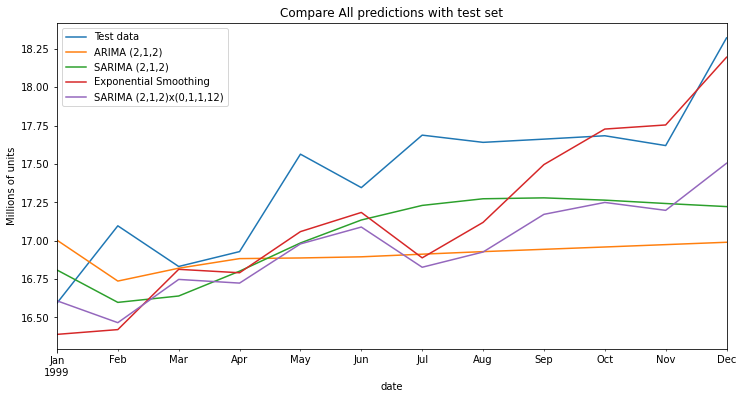

In [28]:
# All on one
title = "Compare All predictions with test set"
xlabel = "date"
ylabel="Millions of units"

ax = test.TOTALSA.plot(legend=True, figsize=(12,6), title=title, label="Test data")
res_arima_2_1_2.plot(legend=True)
res_sarima_2_1_2.plot(legend=True)
res_hw_es.plot(legend=True)
res_arima_2_1_2_seasonal_0_1_1.plot(legend=True)
ax.autoscale(axis="x", tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
plt.show()


### Forecasting

In [29]:
models = [
    dict(
        order=(2,1,2)
    ),
    dict(
        order=(2,1,2),
        seasonal_order=(0,1,1,12)
    )
]
forecasts = [forecast_sarima(df_19.TOTALSA, **i) for i in models]

In [30]:
fcast_es = ExponentialSmoothing(
    df_19.TOTALSA,
    trend='mul',
    seasonal='mul',
    seasonal_periods=12
).fit()
forecasts.append(fcast_es.forecast(12).rename("Exponential Smoothing"))

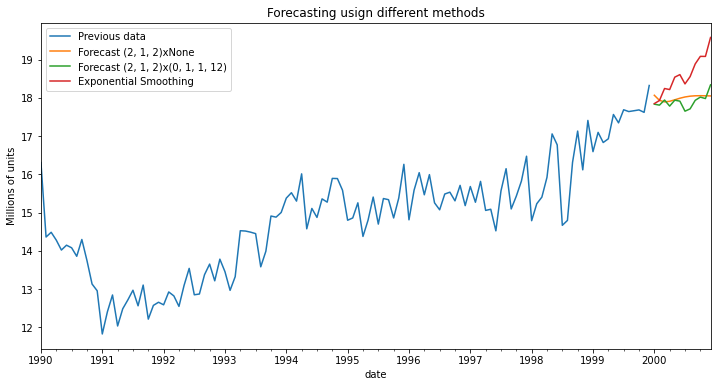

In [31]:
# All on one
title = "Forecasting usign different methods"
xlabel = "date"
ylabel="Millions of units"

ax = df_19.TOTALSA.plot(legend=True, figsize=(12,6), title=title, label="Previous data")
for f in forecasts:
    f.plot(legend=True)
ax.autoscale(axis="x", tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
plt.show()

# Second deacade

In [32]:
df_21 = pd.read_csv("TOTALSA_21.csv", index_col="DATE", parse_dates=True)
df_21.freq="MS"
df_21.head()

,TOTALSA
DATE,
2010-01-01,10.893
2010-02-01,10.315
2010-03-01,11.772
2010-04-01,11.454
2010-05-01,12.030


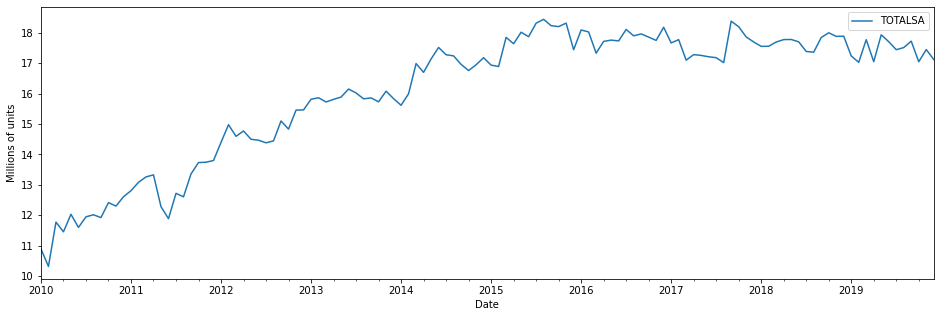

In [33]:
ax = df_21.plot(figsize=(16,5))
plt.ylabel("Millions of units")
plt.xlabel("Date")
plt.show()

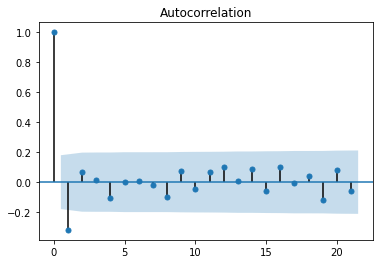

In [34]:
plot_acf(df_21.TOTALSA.diff(1).dropna());

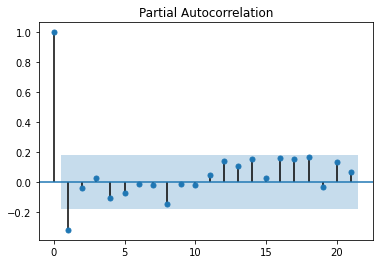

In [35]:
plot_pacf(df_21.TOTALSA.diff(1).dropna());

Look like we sould use the same model, (2,1,2)

In [36]:
s_index = -12
train = df_21.iloc[:s_index]
test = df_21.iloc[s_index:]

Automatic seasonal detection

In [37]:
stepwise = auto_arima(
    df_19.TOTALSA,
    m=12,
    start_p=1,
    start_q=1,
    max_p=4,
    max_q=4,
    max_d=4,
    max_P=4,
    max_D=4,
    max_Q=4,
    stepwise=False,
    trace=True,
    n_jobs=-1
)
stepwise.summary()

Total fit time: 23.219 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:               SARIMAX(2, 1, 2)   Log Likelihood                 -97.640
Date:                Wed, 03 Jun 2020   AIC                            207.280
Time:                        01:36:42   BIC                            223.954
Sample:                             0   HQIC                           214.051
                                - 120                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0046      0.009      0.504      0.614      -0.013       0.022
ar.L1          1.2571      0.097     12.988      0.000       1.067       1.447
ar.L2         -0.4964      0.111     -4.472      0.000      -0.714      -0.279
ma.L1         -1.8311      0.314     -5.832      0.000      -2.446      -1.216
ma.L2          0.9958      0.347      2.872      0.004       0.316       1.676
sigma2         0.2879      0.103      2.792      0.005       0.086       0.490
===================================================================================
Ljung-Box (Q):                       25.31   Jarque-Bera (JB):                 2.15
Prob(Q):                              0.97   Prob(JB):                         0.34
Heteroskedasticity (H):               1.24   Skew:                            -0.31
Prob(H) (two-sided):                  0.50   Kurtosis:                         3.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [38]:
sarima_2_1_2 = SARIMAX(train.TOTALSA, order=(2,1,2)).fit()
res_sarima_2_1_2 = evaluate_model(sarima_2_1_2, len(train), test.TOTALSA, "SARIMA (2,1,2)")

MSE for SARIMA (2,1,2): 	0.4108134503938932
RMSE for SARIMA (2,1,2): 	0.6409473070338101


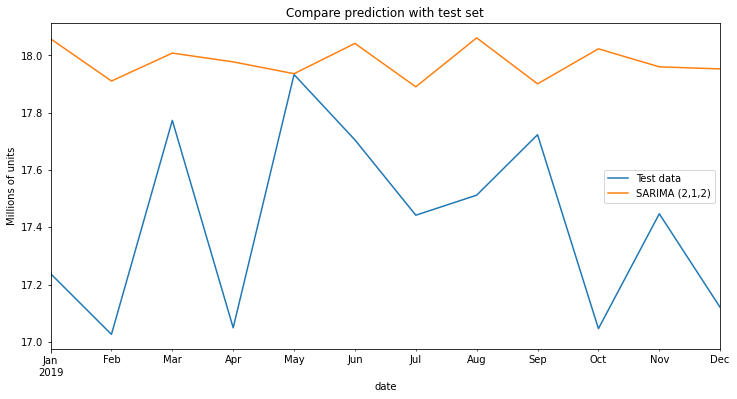

In [39]:
plot_results(test.TOTALSA, res_sarima_2_1_2)

Fixed **D=1** and **d=1**

In [40]:
auto_arima(
    df_19.TOTALSA,
    m=12,
    d=1,
    D=1,
    start_p=1,
    start_q=1,
    max_p=4,
    max_q=4,
#     max_d=4,
    max_P=4,
#     max_D=4,
    max_Q=4,
    stepwise=False,
    trace=True,
    n_jobs=-1
).summary()

Total fit time: 58.293 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  120
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 12)   Log Likelihood                 -99.981
Date:                              Wed, 03 Jun 2020   AIC                            213.961
Time:                                      01:38:23   BIC                            232.671
Sample:                                           0   HQIC                           221.546
                                              - 120                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0037      0.003      1.252      0.211      -0.002       0.010
ar.L1          1.2517      0.120     10.433      0.000       1.017       1.487
ar.L2         -0.4559      0.110     -4.144      0.000      -0.671      -0.240
ma.L1         -1.7903      0.056    -31.901      0.000      -1.900      -1.680
ma.L2          0.9428      0.050     18.892      0.000       0.845       1.041
ma.S.L12      -0.9914      3.000     -0.330      0.741      -6.871       4.888
sigma2         0.2933      0.858      0.342      0.732      -1.388       1.974
===================================================================================
Ljung-Box (Q):                       32.01   Jarque-Bera (JB):                 0.20
Prob(Q):                              0.81   Prob(JB):                         0.91
Heteroskedasticity (H):               1.27   Skew:                            -0.10
Prob(H) (two-sided):                  0.48   Kurtosis:                         3.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [41]:
sarimax_2_1_2_ses_0_1_1 = SARIMAX(train.TOTALSA, order=(2,1,2), seasonal_order=(0,1,1,12)).fit()
res_sarimax_2_1_2_ses_0_1_1 = evaluate_model(
    sarimax_2_1_2_ses_0_1_1,
    len(train),
    test.TOTALSA,
    "SARIMA (2,1,2)x(0,1,1,12)"
)

MSE for SARIMA (2,1,2)x(0,1,1,12): 	0.7237103232176859
RMSE for SARIMA (2,1,2)x(0,1,1,12): 	0.8507116569188916


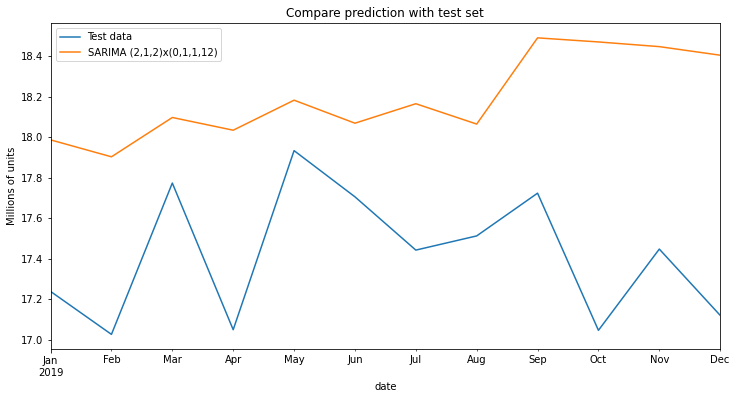

In [42]:
plot_results(test.TOTALSA, res_sarimax_2_1_2_ses_0_1_1)

What will happen if we increase the ORDER of **P**?

In [43]:
sarimax_2_1_2_ses_1_1_1 = SARIMAX(train.TOTALSA, order=(2,1,2), seasonal_order=(1,1,1,12)).fit()
res_sarimax_2_1_2_ses_1_1_1 = evaluate_model(
    sarimax_2_1_2_ses_1_1_1,
    len(train),
    test.TOTALSA,
    "SARIMA (2,1,2)x(1,1,1,12)"
)

MSE for SARIMA (2,1,2)x(1,1,1,12): 	0.8413441581081381
RMSE for SARIMA (2,1,2)x(1,1,1,12): 	0.9172481442380453


It's worse.

Lets try Exponential Smoothing

In [44]:
hw_es2 = ExponentialSmoothing(
    train.TOTALSA,
    trend='mul',
    seasonal='mul',
    seasonal_periods=12
).fit()
res_hw_es2 = hw_es2.forecast(12).rename("Exponential Smoothing")
print(f"MSE for Exponential Smoothing: \t{mean_squared_error(test.TOTALSA, res_hw_es)}")
print(f"RMSE for Exponential Smoothing: \t{rmse(test.TOTALSA, res_hw_es)}")

MSE for Exponential Smoothing: 	0.44475911684650704
RMSE for Exponential Smoothing: 	0.6669026292094724


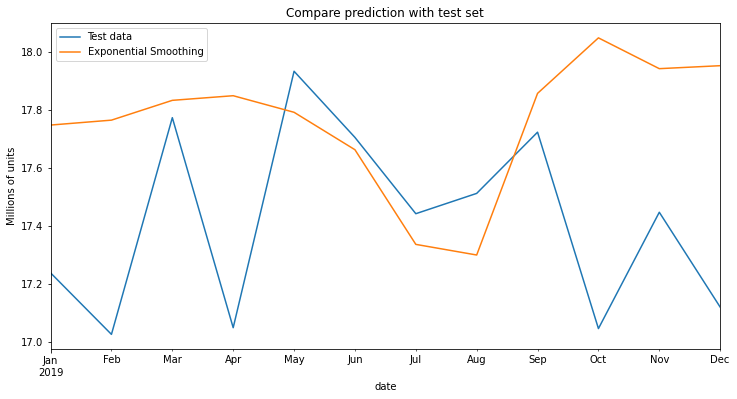

In [57]:
plot_results(test.TOTALSA, res_hw_es2)

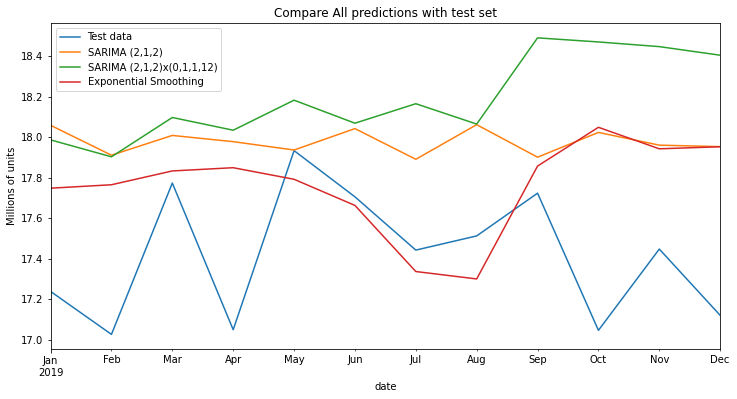

In [58]:
# All on one
title = "Compare All predictions with test set"
xlabel = "date"
ylabel="Millions of units"

ax = test.TOTALSA.plot(legend=True, figsize=(12,6), title=title, label="Test data")
res_sarima_2_1_2.plot(legend=True)
res_sarimax_2_1_2_ses_0_1_1.plot(legend=True)
res_hw_es2.plot(legend=True)
ax.autoscale(axis="x", tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
plt.show()


| Model                           | MSE                | RMSE            |
|-------------------------------- |:------------------:|:---------------:|
| **SARIMA (2,1,2)**              | **0.410**          | **0.640**       |
| SARIMA (2,1,2)x(0,1,1,12)       | 0.723              | 0.850           |
| Exponential Smoothing           | 0.444              | 0.667           |

In [45]:
sarima_models = [
    dict(
        order=(2,1,2)
    ),
    dict(
        order=(2,1,2),
        seasonal_order=(0,1,1,12)
    )
]

forecasts = [forecast_sarima(df_21.TOTALSA, **i) for i in models]

In [46]:
fcast_es = ExponentialSmoothing(
    df_21.TOTALSA,
    trend='mul',
    seasonal='mul',
    seasonal_periods=12
).fit()
forecasts.append(fcast_es.forecast(12).rename("Exponential Smoothing"))

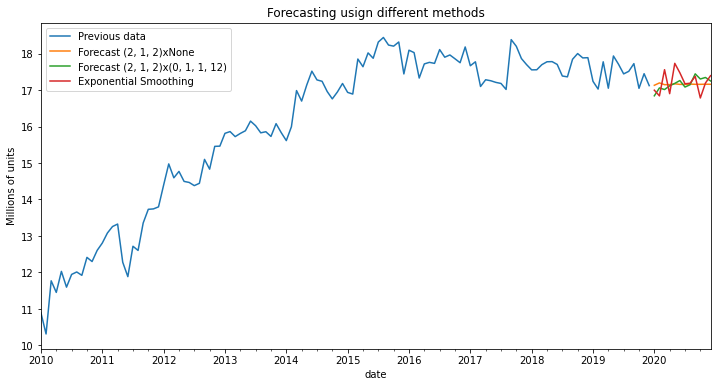

In [47]:
# All on one
title = "Forecasting usign different methods"
xlabel = "date"
ylabel="Millions of units"

ax = df_21.TOTALSA.plot(legend=True, figsize=(12,6), title=title, label="Previous data")
for f in forecasts:
    f.plot(legend=True)
ax.autoscale(axis="x", tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
plt.show()

For the first decade the best model, was ExponentialSmoothing. Adding the seasonality, wasn't decreasing the error. 

For the second decade Exponential Smoothing model and SARIMA(2,1,2) has comparable errors. 